# A simple 1D model implementation


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport import (
    ForcingParameter,
    ForcingUnit,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
    MigratoryTypeParameter,
    NoTransportConfiguration,
)
from seapopym.model import NoTransportModel
from seapopym.standard.coordinate_authority import (
    create_latitude_coordinate,
    create_layer_coordinate,
    create_longitude_coordinate,
    create_time_coordinate,
)
from seapopym.standard.units import StandardUnitsLabels


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. In this NoTransport model, only temperature and primary production are required. The temperature is generated as a sine wave with a period of 1 year and the primary production is randomly generated.


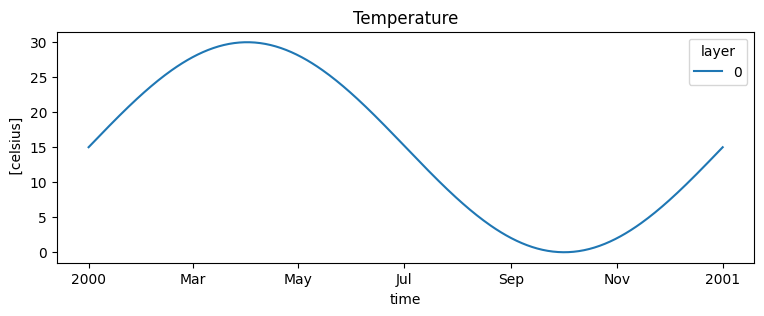

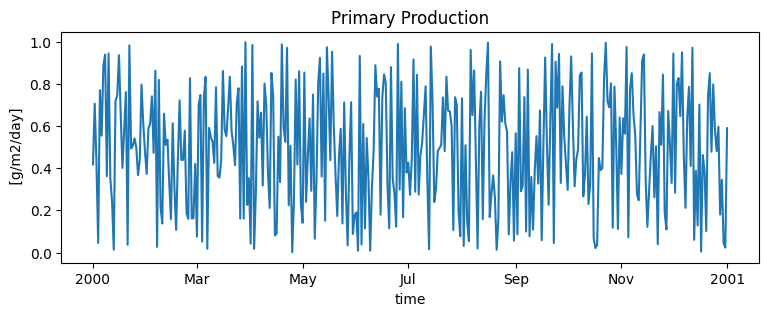

In [2]:
T_axis = create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(T_axis.size)
t = np.linspace(0, 1, n)
temperature = 15 + 15 * np.sin(2 * np.pi * t)
primary_production = 10 + 5 * np.sin(2 * np.pi * t * 365)

temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(
            pd.date_range("2000-01-01", "2001-01-01", freq="D")
        ),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": create_time_coordinate(
            pd.date_range("2000-01-01", "2001-01-01", freq="D")
        ),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
    },
    attrs={"units": "g/m2/day"},
    data=np.random.rand(367, 1, 1),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset(
    {"temperature": temperature, "primary_production": primary_production}
)

## Initialize the model

First we set up the model parameters. We will define two functional groups:

- The first group uses the commonly used parameters for zooplankton in Seapodym LMTL
- The second is a fictitious group where all parameters are arbitrarily divided by 2, simply to demonstrate that multiple functional groups can be declared in a single simulation


In [3]:
day_layer = 0
night_layer = 0
tr_0 = 10.38
gamma_tr = -0.11
lambda_temperature_0 = 1 / 150
gamma_lambda_temperature = 0.15

f_groups = FunctionalGroupParameter(
    functional_group=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            energy_transfert=0.1668,
            migratory_type=MigratoryTypeParameter(
                day_layer=day_layer, night_layer=night_layer
            ),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0,
                gamma_lambda_temperature=gamma_lambda_temperature,
                tr_0=tr_0,
                gamma_tr=gamma_tr,
            ),
        ),
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}_BIS",
            energy_transfert=0.1668 / 2,
            migratory_type=MigratoryTypeParameter(
                day_layer=day_layer, night_layer=night_layer
            ),
            functional_type=FunctionalTypeParameter(
                lambda_temperature_0=lambda_temperature_0 / 2,
                gamma_lambda_temperature=gamma_lambda_temperature / 2,
                tr_0=tr_0 / 2,
                gamma_tr=gamma_tr / 2,
            ),
        ),
    ]
)

p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
)

parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

## Run the model with context manager

The new recommended way to use Seapopym models is with a context manager. This ensures automatic memory cleanup after model execution, which is especially important for genetic algorithms or repeated simulations.


In [4]:
# Recommended: Using context manager for automatic memory cleanup
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    # Extract results while still in context
    biomass = model.state["biomass"].copy()  # Important: copy() for external use

## Plotting the results

### The biomass evolution over T


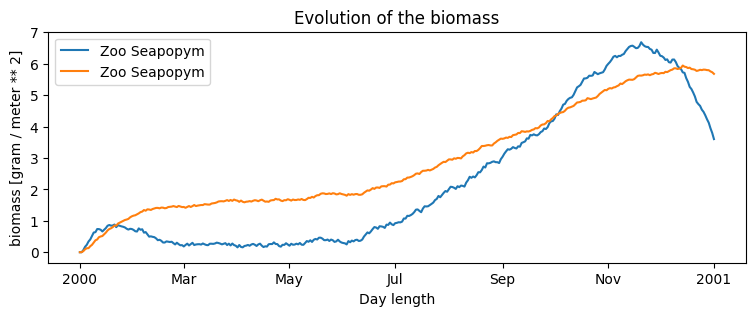

In [5]:
plt.figure(figsize=(9, 3))
biomass.mean(["Y", "X"]).plot(label="Zoo Seapopym", x="T", hue="functional_group")
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

## And now let's do it in parallel


In [ ]:
from dask.distributed import Client

client = Client()

In [7]:
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"].chunk()),
    primary_production=ForcingUnit(forcing=dataset["primary_production"].chunk()),
    parallel=True,
)
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

In [8]:
# Run parallel model with context manager
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    # Extract results for plotting
    parallel_biomass = model.state["biomass"].load().copy()

### The biomass evolution over T


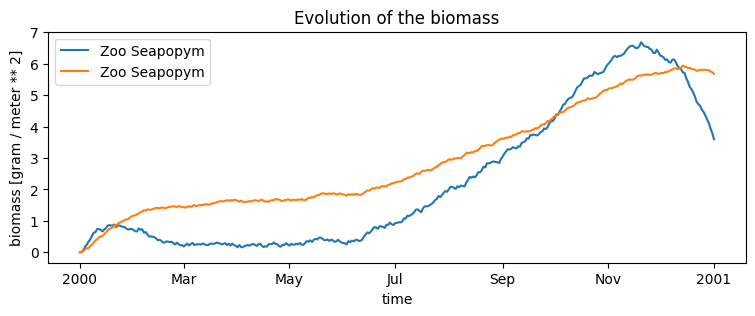

In [9]:
plt.figure(figsize=(9, 3))
parallel_biomass.mean(["Y", "X"]).plot(
    label="Zoo Seapopym", x="T", hue="functional_group"
)
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

# Show weekly model configuration


In [10]:
weekly_dataset = dataset.resample(T="1W").mean().interpolate_na()
p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=weekly_dataset["temperature"]),
    primary_production=ForcingUnit(forcing=weekly_dataset["primary_production"]),
)
parameters = NoTransportConfiguration(forcing=p_param, functional_group=f_groups)

In [11]:
with NoTransportModel.from_configuration(configuration=parameters) as model:
    model.run()
    weekly_biomass = model.state["biomass"].load().copy()

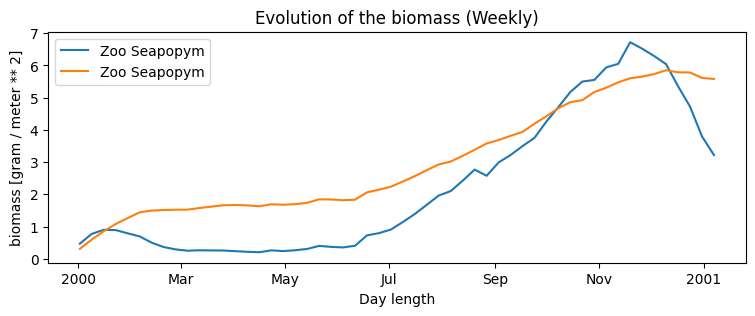

In [12]:
plt.figure(figsize=(9, 3))
weekly_biomass.mean(["Y", "X"]).plot(
    label="Zoo Seapopym", x="T", hue="functional_group"
)
plt.legend()
plt.title("Evolution of the biomass (Weekly)")
plt.show()